In [45]:
import cv2
import numpy as np
import types
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math

In [2]:
'''
    Create a class of key set
'''
class KeySet:
    def __init__(self,key):
        self.key = key

In [3]:
keyset = KeySet("iefgqliuguekqgbgvieugviuberoigvbediovberoivbd")

## Encoding data into image 

In [4]:
'''
    Function that convert any type of data message to binary
'''

def messageToBinary(msg):
    if (type(msg) == str):
        return ''.join([format(ord(i), "08b") for i in msg])
    elif (type(msg) == bytes or type(msg) == np.ndarray):
        return [format(i, "08b") for i in msg]
    elif (type(msg) == int or type(msg) == np.uint8):
        return format(msg, "08b")
    else:
        raise TypeError("Please give valid message")

In [5]:
'''
    Function to hide secret message into image
'''

def hideData (image, secret_msg, keyset):
    # calculate maximum byte to be encoded in RGB image
    if(len(image.shape) == 3):
        n = image.shape[0] * image.shape[1] * 3 // 8
    else:
        n = image.shape[0] * image.shape[1] // 8
    if(len(secret_msg) > n):
        raise valeError("Secret message is overflow please give less amount of data or a bigger image")
    
    # use delimeter for knowing ending of string
    secret_msg += "@#@#" 
    
    data_index = 0
    
    binary_secret_msg = messageToBinary(secret_msg)
    binary_secret_key = messageToBinary(keyset.key)
    
    key_len = len(binary_secret_key)
    data_len = len(binary_secret_msg)
    
    # process to hide binary data into image
    # first we check the given image is single channel image (e.g. grayscale image) or 3 channel image rgb image
    if (len(image.shape) == 3):
        k,l = 0,0
        m,n,ch = image.shape
        while (k < m and l < n):
            for i in range(l,n):
                ## image[k,i]
                r,g,b = messageToBinary(image[k,i,:])
                if (data_index < data_len):
                    image[k,i,0] = int(r[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                if (data_index < data_len):
                    image[k,i,1] = int(g[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                if (data_index < data_len):
                    image[k,i,2] = int(b[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                else:
                    break
            k += 1
            
            for i in range(k, m):
                ## image[i,n-1]
                grey = messageToBinary(image[i,n-1,:])
                if (data_index < data_len):
                    image[i,n-1,0] = int(r[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                if (data_index < data_len):
                    image[i,n-1,1] = int(g[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                if (data_index < data_len):
                    image[i,n-1,2] = int(b[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                else:
                    break
            n -= 1
            
            if (k < m):
                for i in range(n-1,l-1,-1):
                    # image[m-1,i]
                    grey = messageToBinary(image[m-1,i,:])
                    if (data_index < data_len):
                        image[m-1,i,0] = int(r[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                    if (data_index < data_len):
                        image[m-1,i,1] = int(g[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                    if (data_index < data_len):
                        image[m-1,i,2] = int(b[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                    else:
                        break
                m -= 1
            
            if (l < n):
                for i in range(m-1,k-1,-1):
                    #image [i,l]
                    grey = messageToBinary(image[i,l,:])
                    if (data_index < data_len):
                        image[i,l,0] = int(r[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                        image[i,l,1] = int(g[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                        image[i,l,2] = int(b[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                    else:
                        break
                l += 1
        
                    
    elif (len(image.shape) == 2):
        k,l = 0,0
        m,n = image.shape
        while (k < m and l < n):
            for i in range(l,n):
                ## image[k,i]
                grey = messageToBinary(image[k,i])
                if (data_index < data_len):
                    image[k,i] = int(grey[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                else:
                    break
            k += 1
            
            for i in range(k, m):
                ## image[i,n-1]
                grey = messageToBinary(image[i,n-1])
                if (data_index < data_len):
                    image[i,n-1] = int(grey[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                    data_index += 1
                else:
                    break
            n -= 1
            
            if (k < m):
                for i in range(n-1,l-1,-1):
                    # image[m-1,i]
                    grey = messageToBinary(image[m-1,i])
                    if (data_index < data_len):
                        image[m-1,i] = int(grey[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                    else:
                        break
                m -= 1
            
            if (l < n):
                for i in range(m-1,k-1,-1):
                    #image [i,l]
                    grey = messageToBinary(image[i,l])
                    if (data_index < data_len):
                        image[i,l] = int(grey[:-1] + str(ord(binary_secret_msg[data_index]) ^ ord(binary_secret_key[data_index % key_len])), 2)
                        data_index += 1
                    else:
                        break
                l += 1
        
        
    else:
        raise valueError("Given image is not valid")
    return image

In [6]:
'''
    Function to take an input image and data
'''
def encodeText(path, keyset):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    print (f'Shape of given image is {image.shape}')
    
    data = input("Enter your message to be encrypted : ")
    
    encode_image = hideData(image, data, keyset)
    filename, filetype = path.split('.')
    filename += "_stego."+filetype
    cv2.imwrite(filename, encode_image)
    
    plt.figure(figsize = (15,15))
    if (len(image.shape) == 3):
        img = mpimg.imread(path,0)
        plt.subplot(1,2,1),plt.imshow(img),plt.title("Original Image")

        img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    
        plt.subplot(1,2,2),plt.imshow(img),plt.title("Encoded Image")
    elif (len(image.shape) == 2):  
        plt.subplot(1,2,1),plt.imshow(image, cmap='gray', vmin=0, vmax=255),plt.title("Original Image")

        plt.subplot(1,2,2),plt.imshow(encode_image, cmap='gray', vmin=0, vmax=255),plt.title("Encoded Image")

    return filename

Shape of given image is (256, 256)
Enter your message to be encrypted : Secret Message


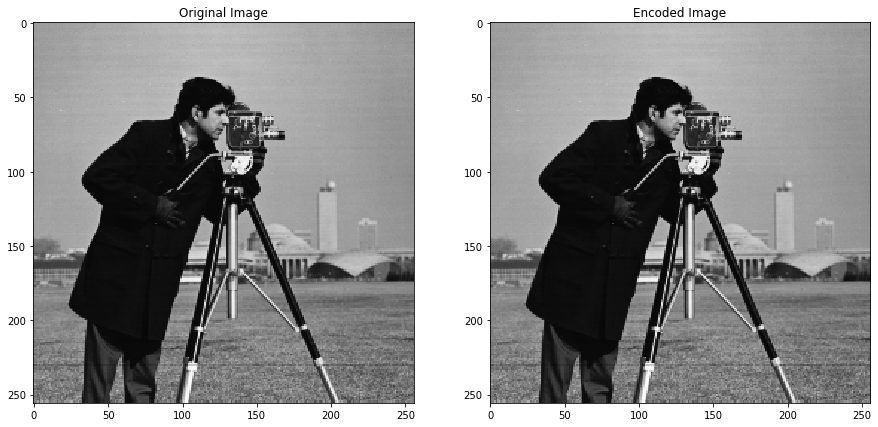

In [14]:
encoded_filename = encodeText("Cover_1.png", keyset)

## Decode data from image

In [31]:
'''
    Function to extract the data from in encoded image
'''
def extractData(image, keyset):
    
    binary_data = ""
    # check whether input image is single or triple channel
    binary_secret_key = messageToBinary(keyset.key)
    
    key_len = len(binary_secret_key)
    key_index = 0
    
    if (len(image.shape) == 3):
        k,l = 0,0
        m,n,ch = image.shape
        while (k < m and l < n):
            for i in range(l,n):
                ## image[k,i]
                r,g,b = messageToBinary(image[k,i])
                binary_data += str(ord(r[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
                binary_data += str(ord(g[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
                binary_data += str(ord(b[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
            k += 1
            
            for i in range(k, m):
                ## image[i,n-1]
                r,g,b = messageToBinary(image[i,n-1])
                binary_data += str(ord(r[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
                binary_data += str(ord(g[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
                binary_data += str(ord(b[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
            n -= 1
            
            if (k < m):
                for i in range(n-1,l-1,-1):
                    # image[m-1,i]
                    r,g,b = messageToBinary(image[m-1,i])
                    binary_data += str(ord(r[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                    binary_data += str(ord(g[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                    binary_data += str(ord(b[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                m -= 1
            
            if (l < n):
                for i in range(m-1,k-1,-1):
                    #image [i,l]
                    r,g,b = messageToBinary(image[i,l])
                    binary_data += str(ord(r[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                    binary_data += str(ord(g[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                    binary_data += str(ord(b[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                l += 1
                
    elif(len(image.shape) == 2):
        k,l = 0,0
        m,n = image.shape
        while (k < m and l < n):
            for i in range(l,n):
                ## image[k,i]
                grey = messageToBinary(image[k,i])
                binary_data += str(ord(grey[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
            k += 1
            
            for i in range(k, m):
                ## image[i,n-1]
                grey = messageToBinary(image[i,n-1])
                binary_data +=  str(ord(grey[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                key_index += 1
            n -= 1
            
            if (k < m):
                for i in range(n-1,l-1,-1):
                    # image[m-1,i]
                    grey = messageToBinary(image[m-1,i])
                    binary_data +=  str(ord(grey[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                m -= 1
            
            if (l < n):
                for i in range(m-1,k-1,-1):
                    #image [i,l]
                    grey = messageToBinary(image[i,l])
                    binary_data +=  str(ord(grey[-1]) ^ ord(binary_secret_key[key_index % key_len]))
                    key_index += 1
                l += 1
                
                
    else:
        raise TypeError("Input image is not valid")
            
        
    
    all_byte = [binary_data [i: i+8] for i in range (0, len(binary_data),8)]
    
    decode_data = ""
    
    for byte in all_byte:
        decode_data += chr(int(byte, 2))
        if (decode_data[-4:] == "@#@#"):
            break
            
    return decode_data[:-4]

In [32]:
'''
    Function to read an encoded image and give text data
'''
def decodeText(path, keyset):
    image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    text = extractData(image, keyset)
    
    return text

In [33]:
decodeText(encoded_filename, keyset)

'Secret Message'

## Code Check

In [34]:
# From KeySet Generate keyset that is private key set for sender and receiver

key = input("Enter the key type alphanumeric : ")
keyset = KeySet(key)

Enter the key type alphanumeric : !@#$%^&*()_+~~`€€€€€€€€€€€€€€


Shape of given image is (256, 256)
Enter your message to be encrypted : The contents of this Email communication are confidential to the addressee. If you are not the intended recipient you may not disclose or distribute this communication in any form should immediately contact the sender. The information, images, documents and views expressed in this Email are personal to the Sender and do not expressly or implicitly represent official positions of DRDO and no authority exists on behalf of DRDO to make any agreements, or other binding commitment by means of Email.



Decoded message of image is : The contents of this Email communication are confidential to the addressee. If you are not the intended recipient you may not disclose or distribute this communication in any form should immediately contact the sender. The information, images, documents and views expressed in this Email are personal to the Sender and do not expressly or implicitly represent official positions of DRDO and no a

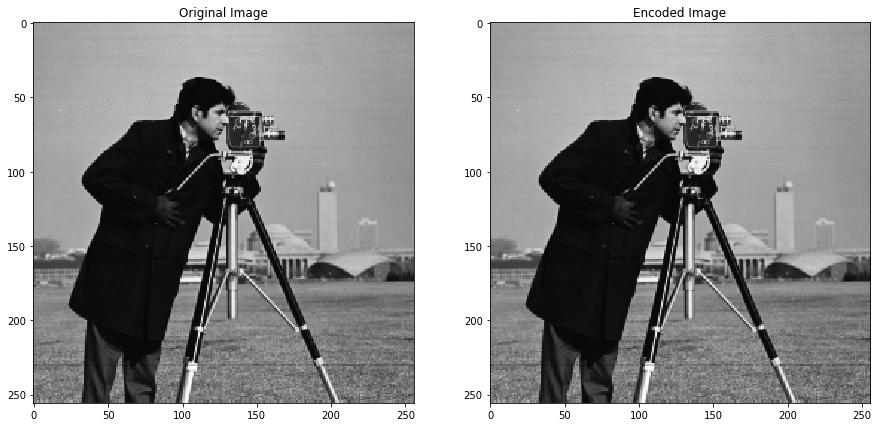

In [48]:
# Encode message in Grayscale image
# Encode the message into image using keyset

output_Image_1 = encodeText("Cover_1.png", keyset)

print('\n\n')
# Decode message from stego image
print(f'Decoded message of image is : {decodeText(output_Image_1, keyset)}')

Shape of given image is (222, 223, 3)
Enter your message to be encrypted : The contents of this Email communication are confidential to the addressee. If you are not the intended recipient you may not disclose or distribute this communication in any form should immediately contact the sender. The information, images, documents and views expressed in this Email are personal to the Sender and do not expressly or implicitly represent official positions of DRDO and no authority exists on behalf of DRDO to make any agreements, or other binding commitment by means of Email.



Decoded message of image is : The contents of this Email communication are confidential to the addressee. If you are not the intended recipient you may not disclose or distribute this communication in any form should immediately contact the sender. The information, images, documents and views expressed in this Email are personal to the Sender and do not expressly or implicitly represent official positions of DRDO and n

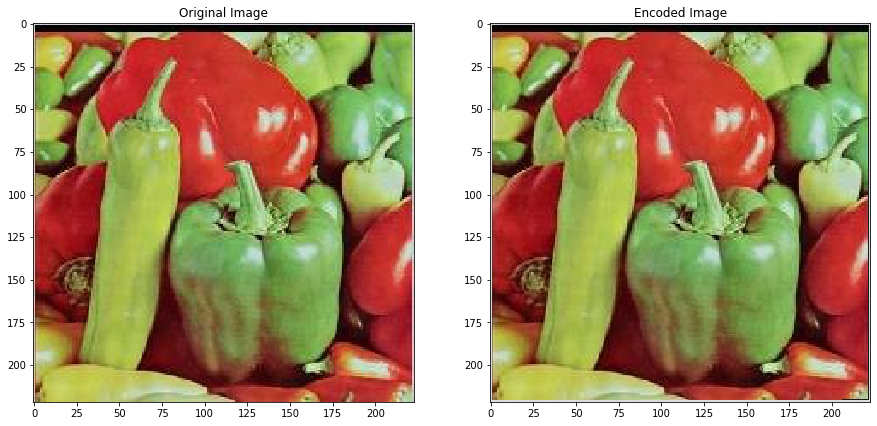

In [49]:
# Encode message in RGB image

# Encode the message into image using keyset
output_Image_1 = encodeText("Cover_2.png", keyset)

print('\n\n')
# Decode message from stego image
print(f'Decoded message of image is : {decodeText(output_Image_1, keyset)}')